In [1]:
import gymnasium as gym
import numpy as np
import pygame
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
class MazeGameEnv(gym.Env):
    def __init__(self, maze, alpha=0.1, gamma=0.99, epsilon=0.1):
        super(MazeGameEnv, self).__init__()
        self.maze = np.array(maze)
        self.start_pos = tuple(np.argwhere(self.maze == 'S')[0])
        self.goal_pos = tuple(np.argwhere(self.maze == 'G')[0])
        self.current_pos = self.start_pos
        self.num_rows, self.num_cols = self.maze.shape

        self.alpha = alpha  # Taxa de aprendizado
        self.gamma = gamma  # Fator de desconto
        self.epsilon = epsilon  # Probabilidade de exploração

        # Define ação como Discrete com 4 ações (cima, baixo, esquerda, direita)
        self.action_space = gym.spaces.Discrete(4)

        # Defina o espaço de observação como uma tupla com o número de linhas e colunas
        self.observation_space = gym.spaces.Tuple((gym.spaces.Discrete(self.num_rows), gym.spaces.Discrete(self.num_cols)))

        # Inicialize o ambiente Pygame
        pygame.init()

        # Defina cores
        self.WHITE = (255, 255, 255)
        self.GREEN = (0, 255, 0)
        self.RED = (255, 0, 0)
        self.BLACK = (0, 0, 0)
        self.PURPLE = (255, 0, 255)
        self.BLUE = (0, 0, 255)

    def reset(self):
        self.current_pos = self.start_pos
        return self.current_pos

    def step(self, action, reward = 1):
        if action == 0:  # Cima
            self.move('up')
        elif action == 1:  # Baixo
            self.move('down')
        elif action == 2:  # Esquerda
            self.move('left')
        elif action == 3:  # Direita
            self.move('right')

        obs = self.current_pos
        #
        if(reward == 1):
            #reward = 1 if self.current_pos == self.goal_pos else 0
            distance_to_goal = abs(self.current_pos[0] - self.goal_pos[0]) + abs(self.current_pos[1] - self.goal_pos[1])
            reward = 1 / (distance_to_goal + 1)  
            done = self.current_pos == self.goal_pos
        else:
            reward = ""
            done = ""
            
        info = {}

        return obs, reward, done, info
    
    def move(self, action):
        new_pos = list(self.current_pos)

        if action == 'up':
            new_pos[0] -= 1
        elif action == 'down':
            new_pos[0] += 1
        elif action == 'left':
            new_pos[1] -= 1
        elif action == 'right':
            new_pos[1] += 1

        new_pos = tuple(new_pos)

        if self.is_valid_position(new_pos[0], new_pos[1]):
            self.current_pos = new_pos

    def is_valid_position(self, row, col):
        return 0 <= row < self.num_rows and 0 <= col < self.num_cols and self.maze[row, col] != '#'


    def render(self, mode='human', path=None):
        if mode == 'human':
            self.draw_maze(path)
            pygame.display.update()
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
        
        if mode == 'blank':
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()

    def play_path(self, path, delay=1):
        for position in path:
            self.current_pos = position
            self.render(mode='human', path=path)
            time.sleep(delay)

    def draw_maze(self, path = None):
        self.cell_size = 50
        self.screen_width = self.num_cols * self.cell_size
        self.screen_height = self.num_rows * self.cell_size
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        self.screen.fill(self.WHITE)
        
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                if self.maze[row, col] == '#':
                    pygame.draw.rect(self.screen, self.BLACK, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':
                    pygame.draw.rect(self.screen, self.GREEN, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'G':
                    pygame.draw.rect(self.screen, self.RED, (cell_left, cell_top, self.cell_size, self.cell_size))
                    
        if path:
            for i in range(len(path)-1):
                start = path[i]
                end = path[i+1]
                self.draw_arrow(start, end)

        current_row, current_col = self.current_pos
        pygame.draw.rect(self.screen, self.PURPLE, (current_col * self.cell_size, current_row * self.cell_size, self.cell_size, self.cell_size))

    def draw_arrow(self, start, end):
        start_x = start[1] * self.cell_size + self.cell_size // 2
        start_y = start[0] * self.cell_size + self.cell_size // 2
        end_x = end[1] * self.cell_size + self.cell_size // 2
        end_y = end[0] * self.cell_size + self.cell_size // 2

        pygame.draw.line(self.screen, self.BLUE, (start_x, start_y), (end_x, end_y), 2)

    def close(self):
        pygame.quit()


In [5]:
maze = [
    ['S', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '#', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '#', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '#', '#', '#', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '#', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '#', '.', '.', '.', '.', '.', '.', '.', 'G'],
]

In [3]:
maze = [
    ['S','.','.','.','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','#','#','#','.','.'],
    ['.','.','.','.','.','G']
]

In [4]:
maze = [
    ['S','.','.','.','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','.','.','G']
]

In [ ]:
env = MazeGameEnv(maze)

done = False
state = env.reset()
env.render()

while not done:
    action = env.action_space.sample()  # Exemplo: selecione uma ação aleatória
    state, reward, done, _ = env.step(action)
    print(state, reward, done)
    env.render()
    pygame.time.delay(100)

print("Done!")
env.close()

In [7]:
class MonteCarlo:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_prob=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        
        self.Q_table = {}
        for row in range(env.num_rows):
            for col in range(env.num_cols):
                state = (row, col)    #destino
                self.Q_table[state] = np.zeros(env.action_space.n)
    
        self.mc_acoe = [0,1,2,3]
        self.mc_reward = -1
        self.VI = np.zeros((env.num_cols, env.num_rows))
        self.otimo = []
        self.converg = 80
        
        self.dest = []
        self.dest.append(list(state))
        self.gamm_arr = {(x, y):list() for x in range(env.num_cols) for y in range(env.num_rows)}
        self.vabs = {(x, y):list() for x in range(env.num_cols) for y in range(env.num_rows)}
        self.sta = [[x, y] for x in range(env.num_cols) for y in range(env.num_rows)] 
        
    def epocas(self):
        begin_state = env.start_pos  
        epocas = []
        while True:
            # Se estado igual destino encerra a epoca
            if list(begin_state) in self.dest:
                self.env.reset()
                return epocas
            # Seleciona de forma randomica uma ação (cima , esquerda, ...   )
            action = random.choice(self.mc_acoe)
            
            # Retorna os novos estados que podem ser utilizados
            new_state, _, _, _ = self.env.step(action, 0)  # valida se tem parede ou borda

            # Cria lista das epocas
            epocas.append([list(begin_state), action, self.mc_reward, list(new_state)])

            begin_state = new_state
        
    def MC(self, mc_interactions):
        conv_epoc = []
        for z in tqdm(range(mc_interactions)):
            epoc = self.epocas()
            ga = 0
            vi_ant = None
            count = 0
            for i, passo in enumerate(epoc[::-1]):
                ga = env.gamma*ga + passo[2]
                # Começa pelas epocas proximas ao destino
                if passo[0] not in [x[0] for x in epoc[::-1][len(epoc)-i:]]:
                    # Pega posicao que vai ser calculada
                    pos = (passo[0][0], passo[0][1])
                    # Monta uma lista de gamma para posição  
                    self.gamm_arr[pos].append(ga)
                    # Calcula a media de todos os gammas da posicao
                    newValue = np.average(self.gamm_arr[pos])
                    # Monta uma lista na posição com o calculo do valor absoluto da diferença entre as posições - antiga e nova
                    self.vabs[pos[0], pos[1]].append(np.abs(self.VI[pos[0], pos[1]]-newValue))
                    # lista com os valores de interacao 
                    self.VI[pos[0], pos[1]] = newValue
                    
            if z >= self.converg:  # convergencia de acordo com o grafico
                conv_epoc.append(epoc)
            
            if z in [100,200,300, 400, mc_interactions-1]:
                print("Iteration {}".format(z+1))
                print(self.VI)
                print("")
                        
            vabs_ant = self.vabs
        
        plt.figure(figsize=(20,10))
        all_series = [list(x)[:100] for x in self.vabs.values()]
        for series in all_series:
            plt.plot(series)
            
        list(map(len, conv_epoc))        
    
        def get_line_len(conv_epoc):
            return len(conv_epoc),conv_epoc
        
        list_converg = sorted(list(map(get_line_len, conv_epoc)))

        print (f'O menos número de passos atingidos em {mc_interactions} interações foram : {list_converg[0][0]}')
        
        print (f'Ocorreu na epoca  {(self.converg + list_converg[0][0])} e é considerado como o resultado ótimo para este treinamento')
        
        steps = list_converg[0][1]
        
        bob_volta_casa = []
        
        for item in steps:
            bob_volta_casa.append((item[3][0], item[3][1]))
        
        return bob_volta_casa
            
    def find_optimal_path(self):
        state = env.start_pos
        optimal_path = [state]

        while state != env.goal_pos:
            action = np.argmax(self.Q_table[state])
            env.move(action)
            state = env.current_pos
            optimal_path.append(state)

        print(self.VI)
        return optimal_path
                

  0%|          | 0/500 [00:00<?, ?it/s]

 23%|██▎       | 114/500 [00:00<00:02, 181.83it/s]

Iteration 101
[[ 0.         -2.49955048 -2.49951511 -2.49896262 -2.49807987 -2.49872473]
 [-2.49999998 -2.4999672  -2.49998492  0.         -2.49341852 -2.49295733]
 [-2.49999333 -2.49998182 -2.49999183  0.         -2.47483484 -2.46287574]
 [-2.49973797 -2.49982326 -2.49993519  0.         -2.42519061 -2.34641984]
 [-2.49942235  0.          0.          0.         -2.27671296 -1.91267241]
 [-2.49574473 -2.48863143 -2.4649237  -2.34984738 -1.88445403  0.        ]]



 50%|█████     | 251/500 [00:01<00:01, 148.10it/s]

Iteration 201
[[ 0.         -2.49971279 -2.49972446 -2.49918159 -2.49877221 -2.49820865]
 [-2.49998896 -2.49997541 -2.49995432  0.         -2.49528415 -2.49323836]
 [-2.49999256 -2.49996608 -2.49999152  0.         -2.47697759 -2.46966264]
 [-2.4997931  -2.49985513 -2.49992032  0.         -2.42775225 -2.37450548]
 [-2.4993398   0.          0.          0.         -2.28175975 -1.98316363]
 [-2.496935   -2.49131719 -2.46292003 -2.35996409 -1.92770239  0.        ]]



 70%|██████▉   | 348/500 [00:02<00:01, 126.27it/s]

Iteration 301
[[ 0.         -2.49927027 -2.49969523 -2.4991985  -2.49856359 -2.49852721]
 [-2.49998999 -2.49996293 -2.49995198  0.         -2.49496849 -2.49288429]
 [-2.49998737 -2.49997643 -2.49998928  0.         -2.47745133 -2.46731992]
 [-2.49971471 -2.49989335 -2.49993359  0.         -2.42986942 -2.36722259]
 [-2.49910983  0.          0.          0.         -2.2876948  -1.95018862]
 [-2.49667839 -2.49051465 -2.45998313 -2.35720896 -1.92588629  0.        ]]



 84%|████████▍ | 420/500 [00:03<00:00, 113.46it/s]

Iteration 401
[[ 0.         -2.49936423 -2.49964035 -2.49925834 -2.49840064 -2.49839706]
 [-2.49998895 -2.49997706 -2.49992542  0.         -2.49447158 -2.49292352]
 [-2.49998448 -2.49997477 -2.49998973  0.         -2.47781391 -2.46526414]
 [-2.49957503 -2.49989304 -2.4999473   0.         -2.43018556 -2.36996788]
 [-2.49892853  0.          0.          0.         -2.28766657 -1.95547659]
 [-2.4966256  -2.48988382 -2.45998156 -2.34948492 -1.9186806   0.        ]]



100%|██████████| 500/500 [00:03<00:00, 126.21it/s]


Iteration 500
[[ 0.         -2.4994995  -2.49966725 -2.49934118 -2.49843038 -2.49854959]
 [-2.49999133 -2.49995185 -2.49993904  0.         -2.49467836 -2.49312646]
 [-2.49997154 -2.49997454 -2.49998362  0.         -2.4772439  -2.46404187]
 [-2.49947472 -2.49982567 -2.49991842  0.         -2.42871212 -2.36741541]
 [-2.4987941   0.          0.          0.         -2.28149551 -1.93324142]
 [-2.49646316 -2.48941224 -2.45940007 -2.3526378  -1.91464753  0.        ]]

O menos número de passos atingidos em 500 interações foram : 23
Ocorreu na epoca  103 e é considerado como o resultado ótimo para este treinamento
Optimal Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (1, 4), (2, 4), (2, 4), (3, 4), (2, 4), (3, 4), (3, 5), (3, 5), (3, 4), (3, 4), (3, 5), (4, 5), (4, 5), (4, 4), (4, 5), (5, 5)]


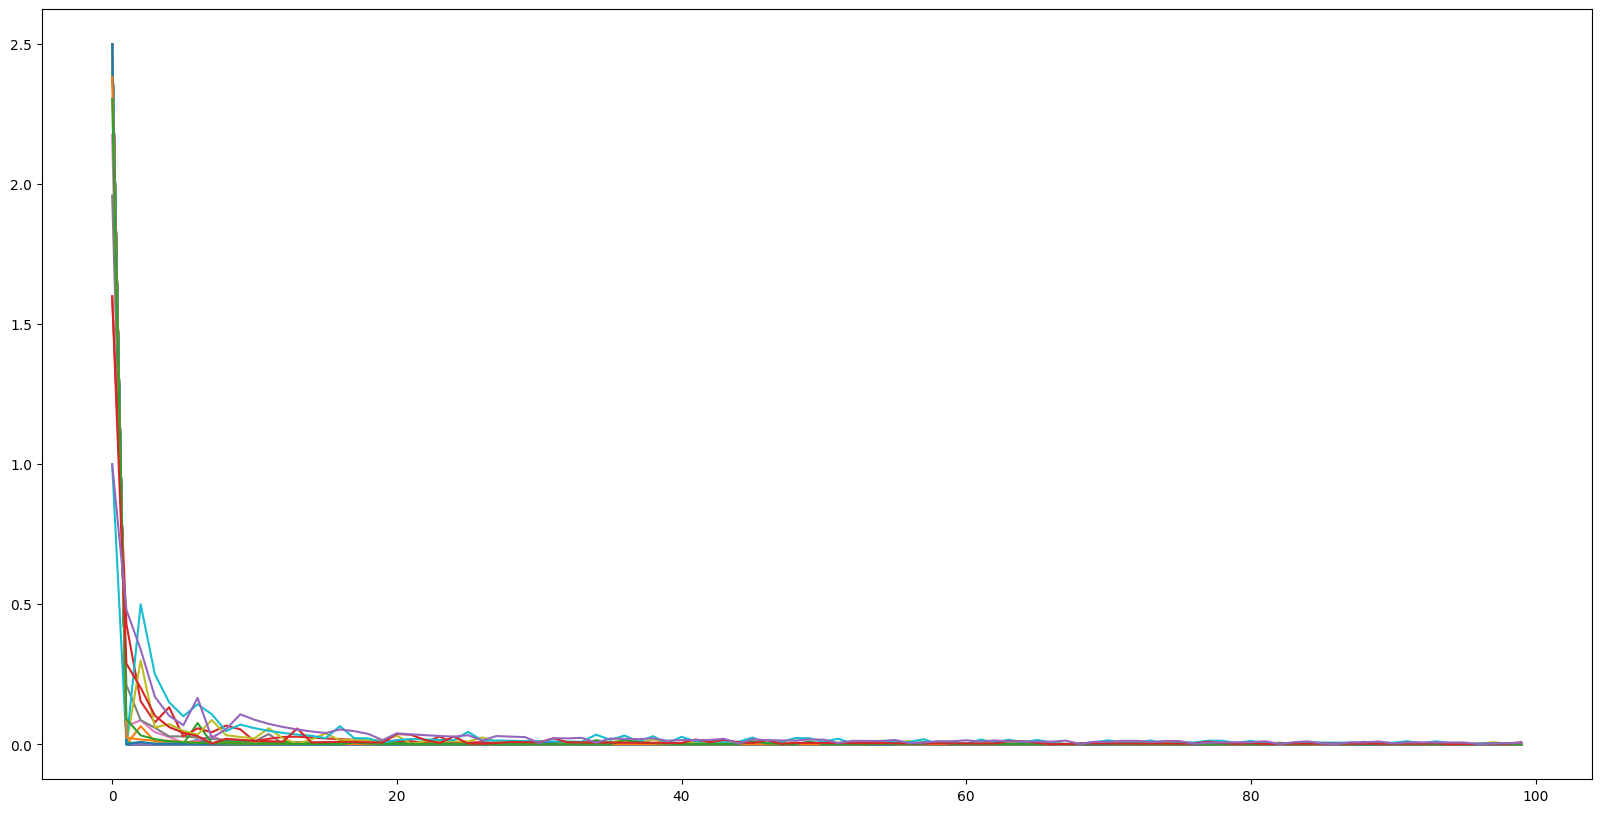

In [11]:
env = MazeGameEnv(maze, alpha=0.1, gamma=0.6, epsilon=0.1)
conf = MonteCarlo(env)
optimal_path = conf.MC(500)

# # Encontre o caminho ótimo do estado inicial ao estado de destino
print("Optimal Path:", optimal_path)
env.play_path(optimal_path)
env.close()

In [4]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.Q = {}
        for row in range(env.num_rows):
            for col in range(env.num_cols):
                self.Q[(row, col)] = {}
                for a in range(env.action_space.n):
                    self.Q[(row, col)][a] = 0
    
    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return max(self.Q[state], key=self.Q[state].get)  # Exploit
    
    def learn(self, state, action, reward, next_state):
        predict = self.Q[state][action]
        target = reward
        if next_state:
            target = reward + self.gamma * max(self.Q[next_state].values())
        
        self.Q[state][action] += self.alpha * (target - predict)
    
    def train(self, episodes):
        for episode in range(episodes):
            path = []  # Lista para armazenar o caminho do episódio atual
            state = self.env.reset()
            path.append(state)
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                path.append(next_state)  # Adicione o estado ao caminho
                self.learn(state, action, reward, next_state)
                state = next_state
                self.env.render()
            self.last_path = path  # Armazene o caminho do último episódio
        self.env.close()
            
    def get_last_path(self):
        return self.last_path


In [6]:
env = MazeGameEnv(maze)
agent = QLearningAgent(env)
agent.train(100)

last_path = agent.get_last_path()
env.play_path(last_path)
env.close()

KeyboardInterrupt: 